In [15]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(broom)
options(repr.matrix.max.rows=6)

In [16]:
#reading the csv file, as well as selecting the columns that are required for building the predictor,
#as well as as the predicted variable as well. Then we filtered for all observations that had values 
#which aren't available. Finally, we mutate the Churn variable into a factor variable.

telecom<-read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")|>
         select(tenure,MonthlyCharges,TotalCharges,Churn)|>
         filter(tenure!="NA")|>
         filter(MonthlyCharges!="NA")|>
         filter(TotalCharges!="NA")|>
         filter(Churn!="NA")|>
         mutate(Churn=as_factor(Churn))

telecom

telecom_churn<-telecom|>
               filter(Churn=="Yes")

telecom_churn

Rows: 7043 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): customerID, gender, Partner, Dependents, PhoneService, MultipleLin...
dbl  (4): SeniorCitizen, tenure, MonthlyCharges, TotalCharges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tenure,MonthlyCharges,TotalCharges,Churn
<dbl>,<dbl>,<dbl>,<fct>
1,29.85,29.85,No
34,56.95,1889.50,No
2,53.85,108.15,Yes
⋮,⋮,⋮,⋮
11,29.60,346.45,No
4,74.40,306.60,Yes
66,105.65,6844.50,No


tenure,MonthlyCharges,TotalCharges,Churn
<dbl>,<dbl>,<dbl>,<fct>
2,53.85,108.15,Yes
2,70.70,151.65,Yes
8,99.65,820.50,Yes
⋮,⋮,⋮,⋮
1,75.75,75.75,Yes
67,102.95,6886.25,Yes
4,74.40,306.60,Yes


In [17]:
#Splitting into dataset into training and testing sets

telecom_split<-initial_split(telecom,prop=0.75,class=Churn)
telecom_train<-training(telecom_split)
telecom_test<-testing(telecom_split)

In [18]:
#Since there are a lot of observations where the Churn variable is no, we need to upsample the dataset, 
#in order to make observations from the two types of Churn values to equal. This allows us to build a 
#more accurate predictor

library(caret)

upsample_telecom_train<-upSample(telecom_train,telecom_train$Churn)|>
                        select(-Churn)|>
                        rename(Churn=Class)

new_upsample_telecom_train<-tibble(upsample_telecom_train)

upsample_telecom_train

new_upsample_telecom_train

tenure,MonthlyCharges,TotalCharges,Churn
<dbl>,<dbl>,<dbl>,<fct>
46,110.20,4972.1,No
19,56.10,1033.9,No
48,24.35,1133.7,No
⋮,⋮,⋮,⋮
4,94.3,424.45,Yes
14,64.7,941.00,Yes
51,84.2,4146.05,Yes


tenure,MonthlyCharges,TotalCharges,Churn
<dbl>,<dbl>,<dbl>,<fct>
46,110.20,4972.1,No
19,56.10,1033.9,No
48,24.35,1133.7,No
⋮,⋮,⋮,⋮
4,94.3,424.45,Yes
14,64.7,941.00,Yes
51,84.2,4146.05,Yes


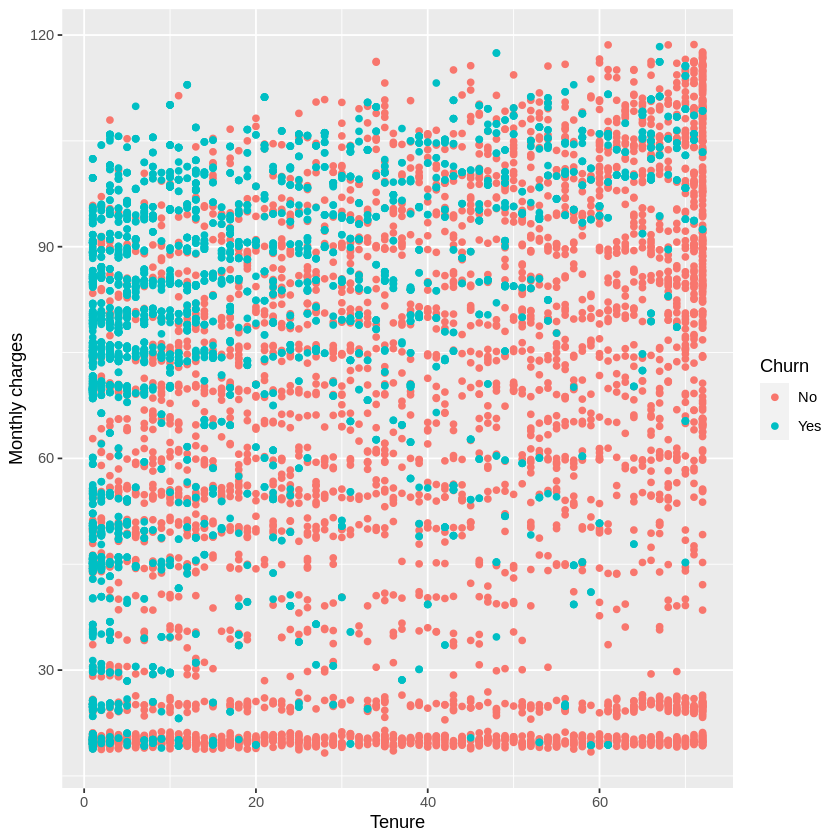

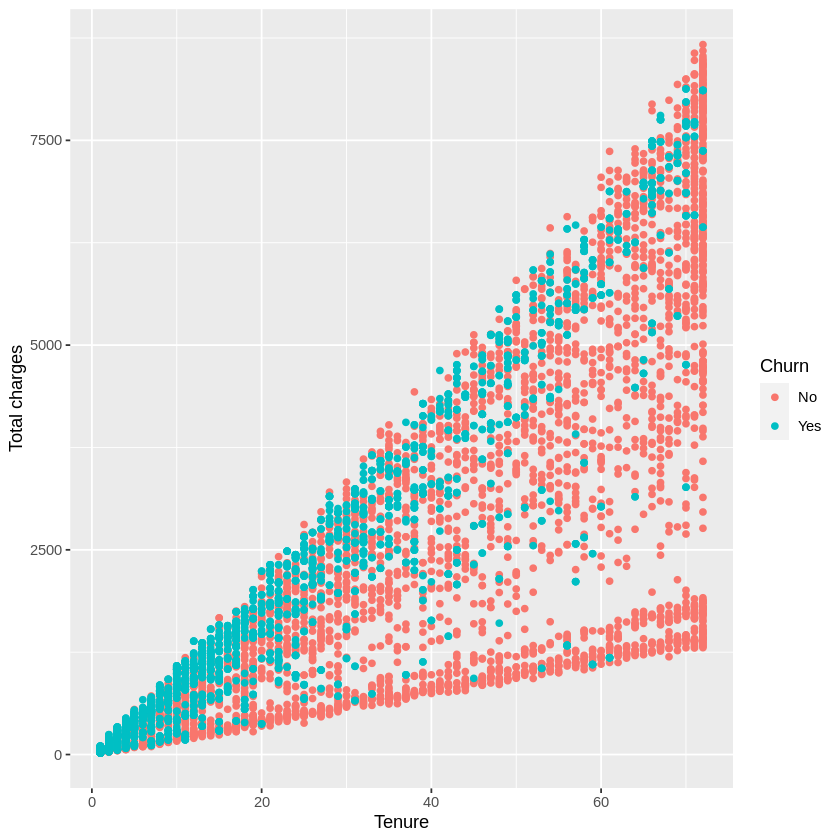

In [19]:
#Plotting the distributions for the new upsampled data, using the predictor variables as x and y axis

new_upsample_telecom_train_plot <- new_upsample_telecom_train |>
                                ggplot(aes(x=tenure, y = MonthlyCharges, color=Churn))+
                                geom_point()+
                                xlab("Tenure") +
                                ylab("Monthly charges")

new_upsample_telecom_train_plot 

new_upsample_telecom_train_plot2 <- new_upsample_telecom_train |>
                                ggplot(aes(x=tenure, y = TotalCharges, color=Churn))+
                                geom_point()+
                                xlab("Tenure") +
                                ylab("Total charges")
new_upsample_telecom_train_plot2



In [20]:
#Computing the means for each of the predictor variables, for the new upsampled dataset

mean_tenure <- new_upsample_telecom_train |>    
               summarize(mean=mean(tenure))

mean_tenure

mean_monthly_charges <-  new_upsample_telecom_train |>    
                         summarize(mean=mean(MonthlyCharges))

mean_monthly_charges


mean_total_charges <-  new_upsample_telecom_train |>    
                         summarize(mean=mean(TotalCharges))

mean_total_charges



mean
<dbl>
28.11595


mean
<dbl>
67.86042


mean
<dbl>
2056.638


In [7]:
#Computing the standard deviations for the 3 predictor variables, for the new upsampled dataset

sd_tenure <- new_upsample_telecom_train |>    
               summarize(sd=sd(tenure))

sd_tenure

sd_monthly_charges <-  new_upsample_telecom_train |>    
                         summarize(sd=sd(MonthlyCharges))

sd_monthly_charges


sd_total_charges <-  new_upsample_telecom_train |>    
                         summarize(sd=sd(TotalCharges))

sd_total_charges



sd
<dbl>
24.0879


sd
<dbl>
28.8334


sd
<dbl>
2194.005


In [8]:
#Building the predictor, using the new upsampled training dataset. We use the KNN-classification method,
# where we first tune the number of neighbors, to determine the K-value that provides the highest 
#accuracy. We include all the predictor variables in the recipe, then use the 5-fold cross-validation 
# method. Afterwards, we include all the components into the workflow, with a grid value of 50, 
#returning the metrics for accuracy estimates.


set.seed(1234)

knn_spec<-nearest_neighbor(weight_func="rectangular",neighbor=tune())|>
          set_engine("kknn")|>
          set_mode("classification")

telecom_recipe<-recipe(Churn~.,data=new_upsample_telecom_train)|>
                step_scale(all_predictors())|>
                step_center(all_predictors()) 

telecom_vfold<-vfold_cv(new_upsample_telecom_train,v=5,strata=Churn)

telecom_workflow<-workflow()|>
                  add_recipe(telecom_recipe)|>
                  add_model(knn_spec)|>
                  tune_grid(resamples=telecom_vfold,grid=50)|>
                  collect_metrics()


telecom_workflow

filtered_telecom_metrics<-telecom_workflow|>
                         filter(.metric=="accuracy")

filtered_telecom_metrics


print(filtered_telecom_metrics)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8481699,5,0.005050402,Preprocessor1_Model01
1,roc_auc,binary,0.8481699,5,0.005050402,Preprocessor1_Model01
2,accuracy,binary,0.8480404,5,0.005050113,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,roc_auc,binary,0.8289729,5,0.002936709,Preprocessor1_Model14
15,accuracy,binary,0.7488975,5,0.002144106,Preprocessor1_Model15
15,roc_auc,binary,0.8287107,5,0.003206781,Preprocessor1_Model15


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8481699,5,0.005050402,Preprocessor1_Model01
2,accuracy,binary,0.8480404,5,0.005050113,Preprocessor1_Model02
3,accuracy,binary,0.7833238,5,0.005578061,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,accuracy,binary,0.7499348,5,0.002349740,Preprocessor1_Model13
14,accuracy,binary,0.7491581,5,0.002557151,Preprocessor1_Model14
15,accuracy,binary,0.7488975,5,0.002144106,Preprocessor1_Model15


# A tibble: 15 × 7
   neighbors .metric  .estimator  mean     n std_err .config              
       <int> <chr>    <chr>      <dbl> <int>   <dbl> <chr>                
 1         1 accuracy binary     0.848     5 0.00505 Preprocessor1_Model01
 2         2 accuracy binary     0.848     5 0.00505 Preprocessor1_Model02
 3         3 accuracy binary     0.783     5 0.00558 Preprocessor1_Model03
 4         4 accuracy binary     0.784     5 0.00582 Preprocessor1_Model04
 5         5 accuracy binary     0.758     5 0.00382 Preprocessor1_Model05
 6         6 accuracy binary     0.759     5 0.00358 Preprocessor1_Model06
 7         7 accuracy binary     0.751     5 0.00404 Preprocessor1_Model07
 8         8 accuracy binary     0.750     5 0.00404 Preprocessor1_Model08
 9         9 accuracy binary     0.747     5 0.00191 Preprocessor1_Model09
10        10 accuracy binary     0.747     5 0.00219 Preprocessor1_Model10
11        11 accuracy binary     0.748     5 0.00290 Preprocessor1_Model11
12    

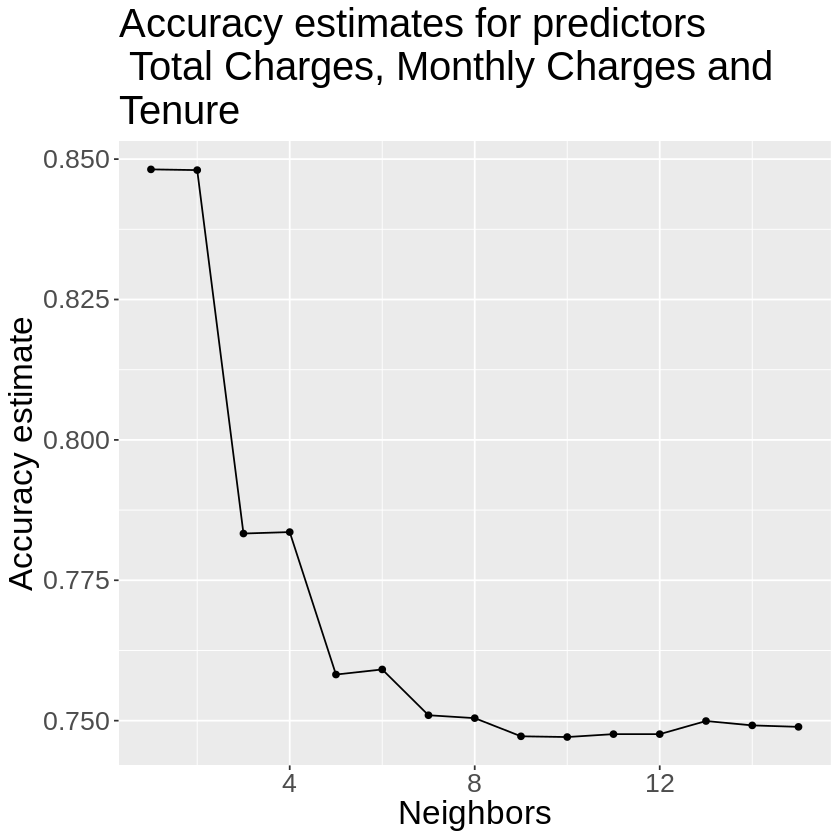

In [13]:
#Plotting a graph for the accuracy estimates, to see which K-value provides the highest one

telecom_k_graph<-filtered_telecom_metrics|>
                 ggplot(aes(x=neighbors,y=mean))+
                 geom_point()+
                 geom_line()+
                 labs(x="Neighbors",y="Accuracy estimate")+
                 ggtitle("Accuracy estimates for predictors \n Total Charges, Monthly Charges and \nTenure")+
                 theme(text=element_text(size=20))

telecom_k_graph

In [10]:
#Given the graph, it seems that a neighbor value of 2 provides the highest accuracy, so we include that
#parameter into the spec function. Afterwards, we use the predictions functions to apply our predictor
#to the test dataset. Finally, we look at the metrics to determine the evenutual accuracy of our 
#predictor, as well as the confusion matrix.

knn_spec_1<-nearest_neighbor(weight_func="rectangular",neighbor=2)|>
          set_engine("kknn")|>
          set_mode("classification")

telecom_workflow_1<-workflow()|>
                    add_recipe(telecom_recipe)|>
                    add_model(knn_spec_1)|>
                    fit(new_upsample_telecom_train)
                             
telecom_test_predictions<-predict(telecom_workflow_1,telecom_test)|>
                          bind_cols(telecom_test)
                             
telecom_test_metrics<-telecom_test_predictions|>
                       metrics(truth=Churn,estimate=.pred_class)|>
                       filter(.metric=="accuracy")
                             
telecom_test_conf_mat<-telecom_test_predictions|>
                       conf_mat(truth=Churn,estimate=.pred_class)
                             
telecom_test_metrics
telecom_test_conf_mat
                  

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7098976


          Truth
Prediction   No  Yes
       No  1020  230
       Yes  280  228